# Package Installation
```python3
# conda update --all 
# conda create -n control-env-3-10 pytest numpy scipy control matplotlib ipykernel slycot pandas python=3.10
```

## Importing Libraries


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import control as ct

## Define Functions

In [22]:
def get_leadlag1(fZero: float, fPole: float, Ts: float) -> ct.StateSpace:

    alpha = fZero / fPole
    fCenter = fPole * np.sqrt(alpha)
    phaseLift = np.arcsin((1.0 - alpha) / (1.0 + alpha)) * (180.0 / np.pi)

    return get_phase_comp(fCenter, phaseLift, Ts)


def get_leadlag2(
    fZero: float, DZero: float, fPole: float, DPole: float, Ts: float
) -> ct.StateSpace:

    wZero = 2 * np.pi * fZero
    wPole = 2 * np.pi * fPole

    wZero = 2 / Ts * np.tan(wZero * Ts / 2)
    wPole = 2 / Ts * np.tan(wPole * Ts / 2)

    k0 = wPole * wPole
    k1 = wZero * wZero
    k2 = Ts * Ts * k0 * k1
    k3 = DPole * Ts * wPole * k1
    k4 = DZero * Ts * k0 * wZero
    k5 = 1 / (k2 + 4 * (k1 + k3))

    b0 = (k2 + 4 * (k4 + k0)) * k5
    b1 = 2 * (k2 - 4 * k0) * k5
    b2 = (k2 + 4 * (k0 - k4)) * k5
    a1 = 2 * (k2 - 4 * k1) * k5
    a2 = (k2 + 4 * (k1 - k3)) * k5

    B = [b0, b1, b2]
    A = [1, a1, a2]

    return ct.tf2ss(ct.TransferFunction(B, A, Ts))


def get_lowpass1(fcut: float, Ts: float) -> ct.StateSpace:

    a1 = -np.exp(-Ts * 2 * np.pi * fcut)
    b0 = 1 + a1

    B = [b0, 0]
    A = [1, a1]

    return ct.tf2ss(ct.TransferFunction(B, A, Ts))


def get_lowpass2(fcut: float, D: float, Ts: float) -> ct.StateSpace:

    wcut = 2 * np.pi * fcut
    k1 = 2 * D * Ts * wcut

    a2 = 1 / (Ts**2 * wcut**2 + k1 + 1)
    a1 = -(k1 + 2) * a2
    b0 = 1 + a1 + a2

    B = [b0, 0, 0]
    A = [1, a1, a2]

    return ct.tf2ss(ct.TransferFunction(B, A, Ts))


def get_notch(fcut: float, D: float, Ts: float) -> ct.StateSpace:

    Q = 1 / (2 * D)
    #  prewarp is done implicitly
    omega = 2 * np.pi * fcut * Ts
    sn = np.sin(omega)
    cs = np.cos(omega)
    alpha = sn / (2 * Q)

    b0 = 1 / (1 + alpha)
    b1 = -2 * cs / (1 + alpha)
    b2 = b0
    a1 = b1
    a2 = (1 - alpha) / (1 + alpha)

    B = [b0, b1, b2]
    A = [1, a1, a2]

    return ct.tf2ss(ct.TransferFunction(B, A, Ts))


def get_phase_comp(fCenter: float, phaseLift: float, Ts: float) -> ct.StateSpace:

    omega = 2.0 * np.pi * fCenter * Ts
    sn = np.sin(phaseLift * np.pi / 180)
    gain = (1 + sn) / (1 - sn)
    # approximate prewarping (series expansion)
    alpha = (12 - omega**2) / (6 * omega * np.sqrt(gain))
    k = 1.0 / (1.0 + alpha)

    b0 = (1 + alpha * gain) * k
    b1 = (1 - alpha * gain) * k
    a1 = (1 - alpha) * k

    B = [b0, b1]
    A = [1, a1]

    return ct.tf2ss(ct.TransferFunction(B, A, Ts))


def bode_plot(G: ct.StateSpace, freq: np.ndarray) -> None:

    mag, phase, _ = G.frequency_response(2.0 * np.pi * freq)

    plt.figure()
    plt.subplot(2, 1, 1)
    plt.semilogx(freq, 20 * np.log10(mag))
    plt.grid(True)
    plt.ylabel("Magnitude (dB)")
    plt.subplot(2, 1, 2)
    plt.semilogx(freq, phase * (180.0 / np.pi))
    plt.grid(True)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Phase (deg)")
    plt.show()

## Stuff

In [23]:
Ts = 50.0e-6
freq = np.logspace(0, np.log10(0.99 / (2.0 * Ts)), 1000)

## Run Test

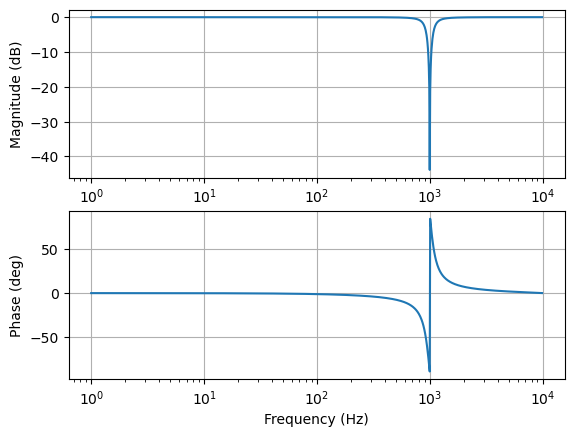

In [24]:
# define NOTCH_F_CUT 1.0e3f
# define NOTCH_D 0.1f

fn = 1.0e3
Dn = 0.1

G = get_notch(fn, Dn, Ts)

bode_plot(G, freq)